In [1]:
import pandas as pd
import json
import os
from sklearn import model_selection, preprocessing, metrics
import datetime
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import gc
import seaborn as sns
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GroupKFold
import seaborn as sns
plt.style.use('ggplot')
from tqdm import tqdm
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers
from pandas.io.json import json_normalize
import matplotlib
matplotlib.style.use('ggplot')#使用ggplot样式

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pydotplus

Using TensorFlow backend.


In [10]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(open(csv_path), 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

##### 导入训练集

In [11]:
%%time
train_data=load_df(r'input/train.csv')
gc.collect()

Loaded train.csv. Shape: (903653, 55)
Wall time: 3min 35s


In [12]:
train_data.shape

(903653, 55)

In [17]:
train_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [13]:
train_data.to_csv('extracted_train.csv',index=False)

##### 导入测试集

In [14]:
%%time
test_data=load_df('input/test.csv')
gc.collect()

Loaded test.csv. Shape: (804684, 53)
Wall time: 3min 21s


In [15]:
test_data.shape

(804684, 53)

In [8]:
test_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country',
       'region', 'metro', 'city', 'networkDomain', 'campaign', 'source',
       'medium', 'keyword', 'isTrueDirect', 'referralPath', 'adContent',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType',
       'adwordsClickInfo.isVideoAd', 'hits', 'pageviews', 'newVisits',
       'bounces'],
      dtype='object')

In [16]:
test_data.to_csv('extracted_test.csv')

### 第二次数据集（数据清洗）

In [3]:
%%time
train_data=pd.read_csv('input/extracted_train.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})

Wall time: 19.1 s


In [14]:
train_data.shape

(903653, 55)

In [4]:
%%time
test_data=pd.read_csv('input/extracted_test.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})

Wall time: 17.7 s


In [16]:
test_data.shape

(804684, 53)

In [6]:
all_data=pd.concat([train_data,test_data])
all_data.shape

(1708337, 55)

**先去除常数列**

In [5]:
const_cols = [c for c in train_data.columns if train_data[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [6]:
for col in const_cols:
    try:
        del train_data[col]
    except:
        pass
    try:
        del test_data[col]
    except:
        pass

In [19]:
train_data.shape

(903653, 36)

In [20]:
test_data.shape

(804684, 34)

In [21]:
set(train_data.columns).difference(set(test_data.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

#### 准备可视化专用数据集

In [11]:
EDA_train=train_data

### 处理目标特征中的异常值

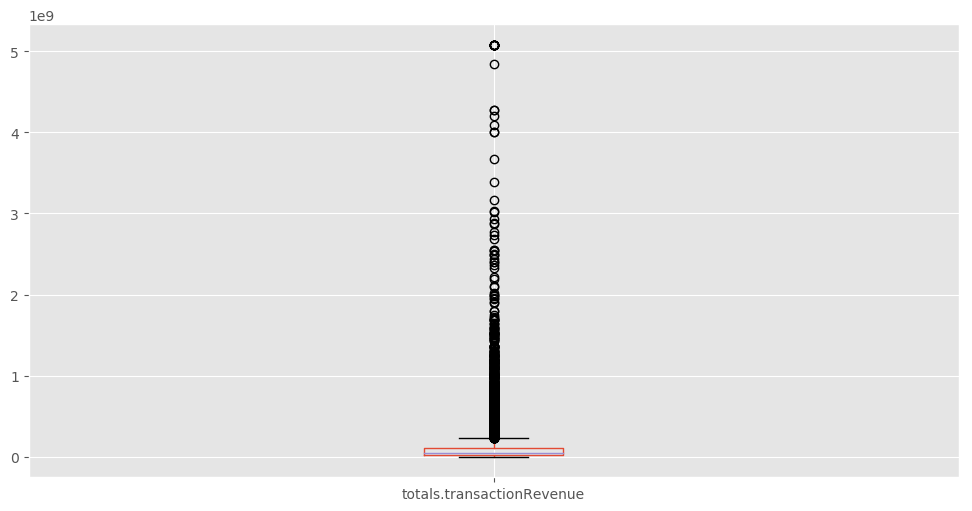

In [13]:
plt.figure(figsize=(12,6),dpi=100)
train_data['totals.transactionRevenue'].plot('box')
plt.savefig('totals.transactionRevenue.png')

In [12]:
threshold=EDA_train['totals.transactionRevenue'].describe([.99])['99%']
EDA_train['totals.transactionRevenue'][EDA_train['totals.transactionRevenue']>threshold*4]=threshold*4

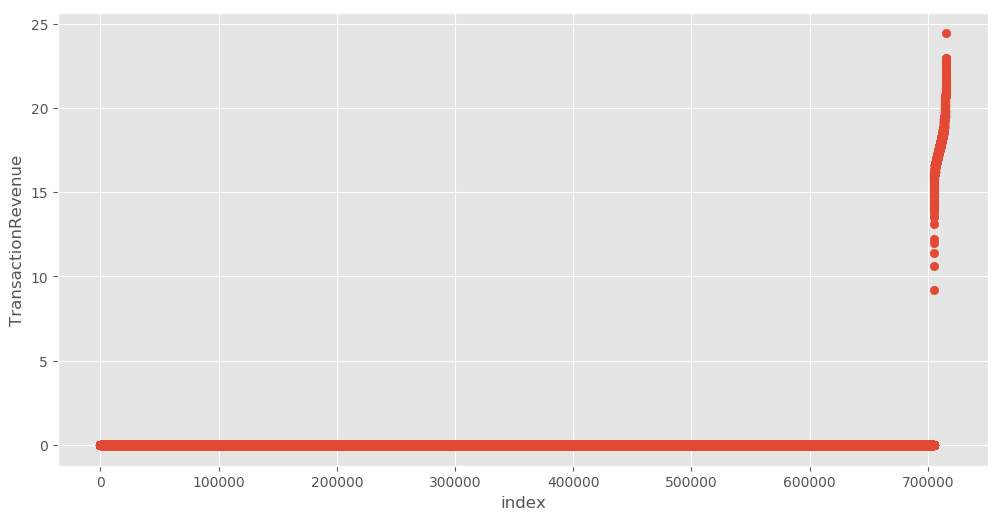

In [15]:
EDA_train["totals.transactionRevenue"] =EDA_train["totals.transactionRevenue"].astype('float')
gdf = EDA_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(12,6),dpi=100)
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.savefig('totals_transactionRevenue_distribution.png')
plt.show()

In [16]:
nzi = pd.notnull(EDA_train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / EDA_train.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  10004 and the ratio is :  0.01398928010582854


**缺失值探索**

In [8]:
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
train_missing = find_missing(train_data)
test_missing = find_missing(test_data)
train_missing.reset_index()[['index', 'missing_ratio']]\
    .merge(test_missing.reset_index()[['index', 'missing_ratio']], on='index', how='left')\
    .rename(columns={'index':'columns', 'missing_ratio_x':'train_missing_ratio', 'missing_ratio_y':'test_missing_ratio'})\
    .sort_values(['train_missing_ratio', 'test_missing_ratio'], ascending=False)\
    .query('train_missing_ratio>0')

,columns,train_missing_ratio,test_missing_ratio
30,trafficSource.campaignCode,0.999999,NaN
23,trafficSource.adContent,0.987887,0.933153
22,totals.transactionRevenue,0.987257,NaN
24,trafficSource.adwordsClickInfo.adNetworkType,0.976252,0.933124
26,trafficSource.adwordsClickInfo.isVideoAd,0.976252,0.933124
27,trafficSource.adwordsClickInfo.page,0.976252,0.933124
28,trafficSource.adwordsClickInfo.slot,0.976252,0.933124
25,trafficSource.adwordsClickInfo.gclId,0.976140,0.933064
31,trafficSource.isTrueDirect,0.696781,0.676254
34,trafficSource.referralPath,0.633774,0.707558


In [78]:
missing_cols2_cat=['trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.isTrueDirect','trafficSource.referralPath','trafficSource.keyword']
for col in missing_cols2_cat:
    describe=all_data[col].describe()
    describe['frequency']=describe['freq']/describe['count']
    print(describe)

count           75274
unique              3
top           Content
freq            42223
frequency    0.560924
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: object
count        75274
unique           1
top          False
freq         75274
frequency        1
Name: trafficSource.adwordsClickInfo.isVideoAd, dtype: object
count           75274
unique              3
top               RHS
freq            42750
frequency    0.567925
Name: trafficSource.adwordsClickInfo.slot, dtype: object
count                             75423
unique                            59008
top          CN_Whvvc_9UCFd6LswodGTgKCQ
freq                                 74
frequency                   0.000981133
Name: trafficSource.adwordsClickInfo.gclId, dtype: object
count        534518
unique            1
top            True
freq         534518
frequency         1
Name: trafficSource.isTrueDirect, dtype: object
count         566264
unique          3196
top                /
freq          138293
frequency 

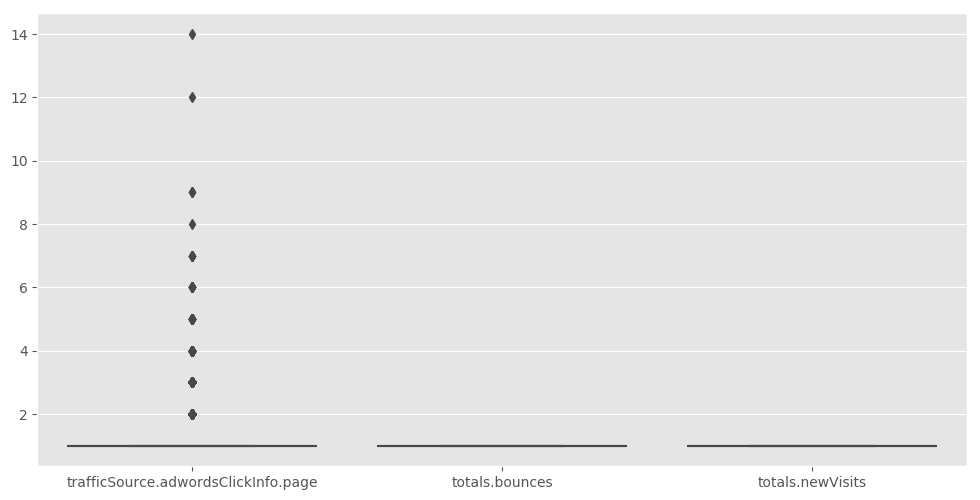

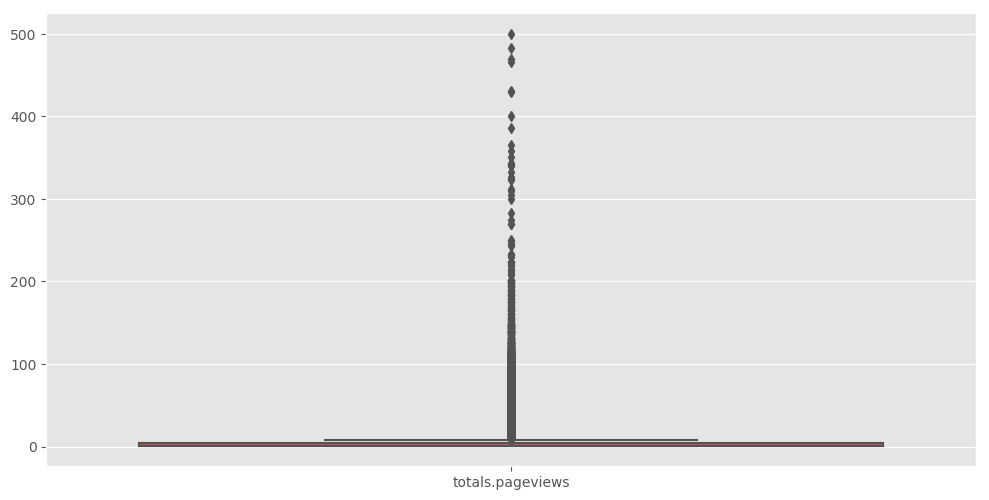

In [88]:
missing_cols2_num=['trafficSource.adwordsClickInfo.page','totals.bounces','totals.newVisits']#,'totals.pageviews'
plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(data=all_data[missing_cols2_num])
plt.savefig('miss_num1.png')

missing_cols2_num=['totals.pageviews']#,'totals.pageviews'
plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(data=all_data[missing_cols2_num])
plt.savefig('miss_num2.png')

In [128]:
for col in ['trafficSource.adwordsClickInfo.page','totals.bounces','totals.newVisits','totals.pageviews']:
    describe=all_data[col].describe()
    print(describe)

count    957467.000000
mean         -0.840778
std           0.548802
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max          14.000000
Name: trafficSource.adwordsClickInfo.page, dtype: float64
count    871578.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: totals.bounces, dtype: float64
count    1307430.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: totals.newVisits, dtype: float64
count    1.708098e+06
mean     3.696202e+00
std      6.473237e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      5.000000e+02
Name: totals.pageviews, dtype: float64


探索变量与是否购物有关

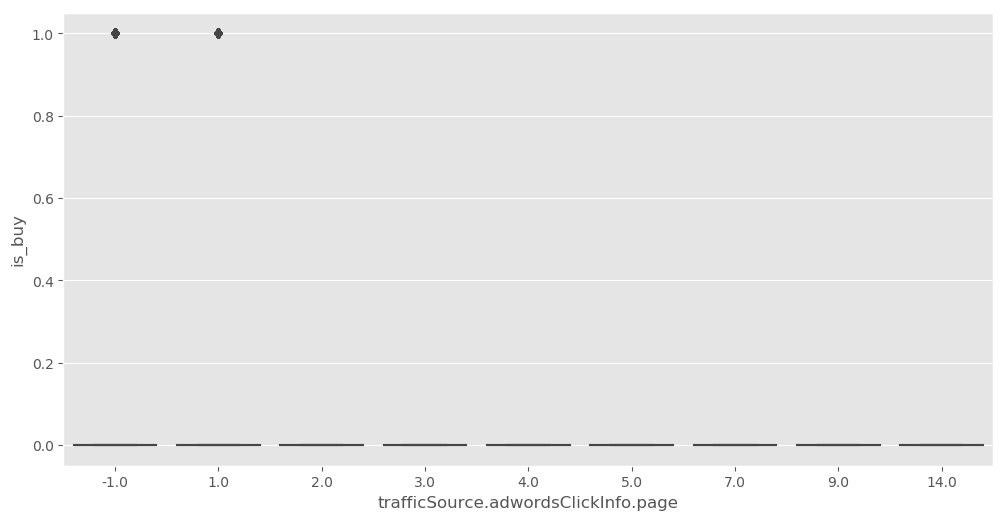

In [116]:
EDA_train['is_buy']=train_data['totals.transactionRevenue']>0
EDA_train['trafficSource.adwordsClickInfo.page'].fillna(-1,inplace=True)

plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(x='trafficSource.adwordsClickInfo.page',y='is_buy',data=EDA_train)
plt.savefig('trafficSource.adwordsClickInfo.page.png')

#EDA_train.groupby('trafficSource.adwordsClickInfo.page')['is_buy'].agg(['mean','std'])

## 开始填充数值型变量

In [7]:
def f(x):
    if x>1:
        return 2
    else:
        return x

def filling_missing_data(df):
    df['totals.bounces'].fillna(0,inplace=True)
    df['totals.newVisits'].fillna(0,inplace=True)
    df['totals.pageviews'].fillna(1,inplace=True)
    df['trafficSource.adwordsClickInfo.page'].fillna(-1,inplace=True)
    df['trafficSource.adwordsClickInfo.page']=df.ix[:,'trafficSource.adwordsClickInfo.page'].apply(f)
    
filling_missing_data(train_data)
filling_missing_data(test_data)

In [23]:
print(train_data.shape,test_data.shape)

(903653, 36) (804684, 34)


#### 填充类型变量

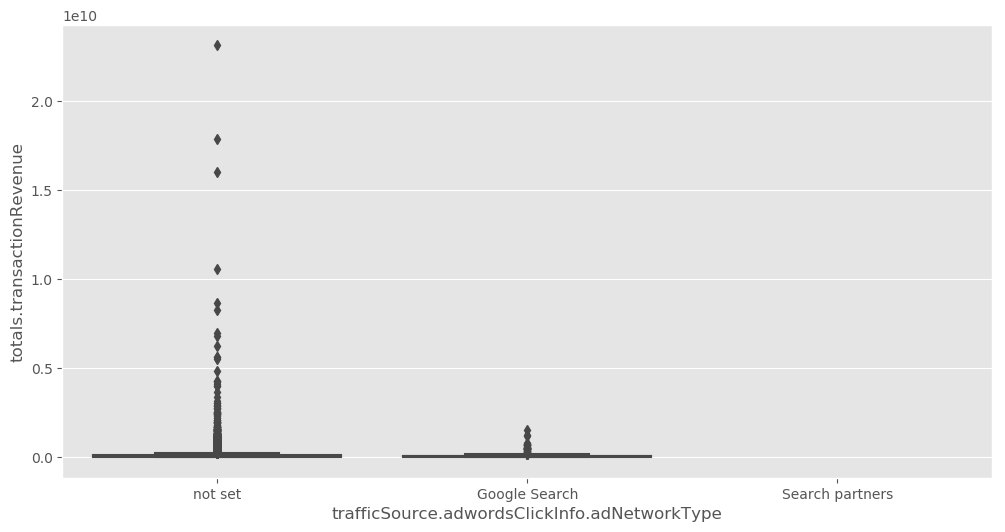

In [195]:
EDA_train['trafficSource.adwordsClickInfo.adNetworkType'].fillna('not available in demo dataset',inplace=True)

# plt.figure(figsize=(12,6),dpi=100)
# sns.boxplot(x='trafficSource.adwordsClickInfo.adNetworkType',y='is_buy',data=EDA_train)
# plt.savefig('trafficSource.adwordsClickInfo.page.png')

#EDA_train.groupby('trafficSource.adwordsClickInfo.adNetworkType')['totals.transactionRevenue'].agg(['mean','std'])

plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(x='trafficSource.adwordsClickInfo.adNetworkType',y='totals.transactionRevenue',data=EDA_train)
plt.savefig('trafficSource.adwordsClickInfo.adNetworkType.png')

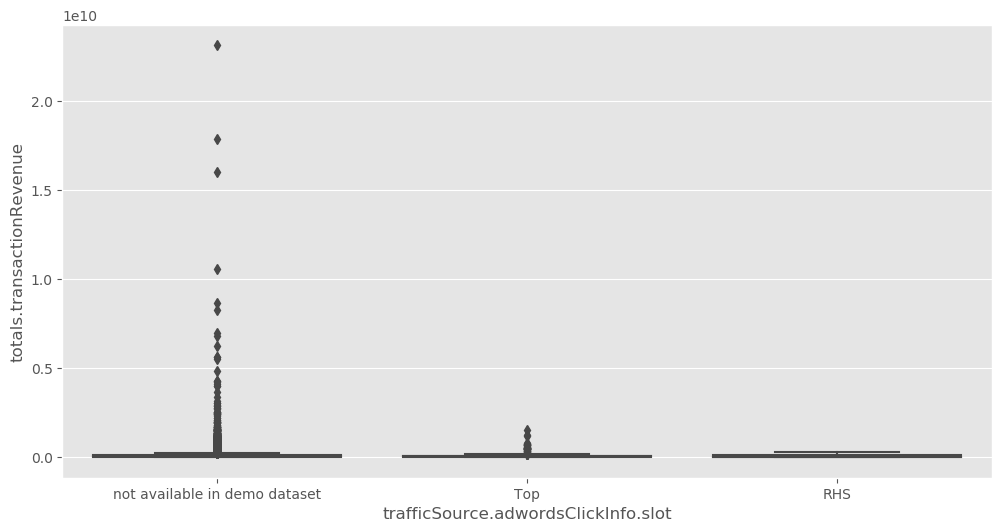

In [197]:
EDA_train['trafficSource.adwordsClickInfo.slot'].fillna('not available in demo dataset',inplace=True)
plt.figure(figsize=(12,6),dpi=100)
sns.boxplot(x='trafficSource.adwordsClickInfo.slot',y='totals.transactionRevenue',data=EDA_train)
#plt.savefig('trafficSource.adwordsClickInfo.adNetworkType.png')

## 开始填充类型变量

In [8]:
def filling_missing_data_cat(df):
    df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('not available in demo dataset',inplace=True)
    df['trafficSource.adwordsClickInfo.adNetworkType'].replace('Content','not available in demo dataset',inplace=True)
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True,inplace=True)
    df['trafficSource.isTrueDirect'].fillna(False,inplace=True)
    df['trafficSource.adwordsClickInfo.slot'].fillna('not available in demo dataset',inplace=True)
    df['trafficSource.adwordsClickInfo.gclId'].fillna('not available in demo dataset',inplace=True)
    df['trafficSource.referralPath'].fillna('not available in demo dataset',inplace=True)
    df['trafficSource.keyword'].fillna('not available in demo dataset',inplace=True)
    df['trafficSource.adContent'].fillna('not available in demo dataset',inplace=True)


filling_missing_data_cat(train_data)
filling_missing_data_cat(test_data)

IndexError: index 21 is out of bounds for axis 0 with size 3

In [28]:
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
train_missing = find_missing(train_data)
test_missing = find_missing(test_data)
train_missing.reset_index()[['index', 'missing_ratio']]\
    .merge(test_missing.reset_index()[['index', 'missing_ratio']], on='index', how='left')\
    .rename(columns={'index':'columns', 'missing_ratio_x':'train_missing_ratio', 'missing_ratio_y':'test_missing_ratio'})\
    .sort_values(['train_missing_ratio', 'test_missing_ratio'], ascending=False)\
    .query('train_missing_ratio>0')

,columns,train_missing_ratio,test_missing_ratio
30,trafficSource.campaignCode,0.999999,NaN
22,totals.transactionRevenue,0.987257,NaN


In [25]:
print(train_data.shape,test_data.shape)

(903653, 36) (804684, 34)


### 删除列

In [ ]:
missing_cols=['trafficSource.campaignCode']#,'totals.transactionRevenue'
for col in missing_cols:
    try:
        del train_data[col]
    except:
        pass
    try:
        del test_data[col]
    except:
        pass

### 重复值去除

In [ ]:
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train_data['device.browser'] = train_data['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train_data['trafficSource.adContent'] = train_data['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train_data['trafficSource.source'] =train_data['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test_data['device.browser'] = test_data['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test_data['trafficSource.adContent'] = test_data['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test_data['trafficSource.source'] = test_data['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

In [39]:
print(train_data.shape,test_data.shape)

(903653, 72) (804684, 71)


### 第二次输出新的数据集

In [29]:
train_data.to_csv('input/second_train.csv',index=False)
test_data.to_csv('input/second_test.csv',index=False)

### 继续数据清洗

In [31]:
train_data=pd.read_csv('input/second_train.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})
test_data=pd.read_csv('input/second_test.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})

In [32]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test_data[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train_data.loc[train_data[columnname].map(lambda x: x not in common), columnname] = 'other'
    test_data.loc[test_data[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train_data[columnname].nunique(), "categories in train")

In [34]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 5 device.browser categories to 'other'; now there are 8 categories in train
Set 15 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 0 trafficSource.adContent categories to 'other'; now there are 3 categories in train
Set 23 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categories

In [9]:
train_data.to_csv('input/third_train.csv',index=False)
test_data.to_csv('input/third_test.csv',index=False)

KeyboardInterrupt: 

## 数据探索

In [2]:
test_data=pd.read_csv('input/third_test.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})
train_data=pd.read_csv('input/third_train.csv',dtype={'date': str, 'fullVisitorId': str, 'sessionId':str,'visitStartTime':str,'visitId':str})

In [41]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_data.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_data.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_data.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [40]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_data['date'] = train_data['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_data.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [43]:
# Continent
cnt_srs = train_data.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_data.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_data.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [46]:
# Continent
cnt_srs = train_data.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_data.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [50]:
# Page views
cnt_srs = train_data.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_data.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.26, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



False    901942
True       1711
dtype: int64

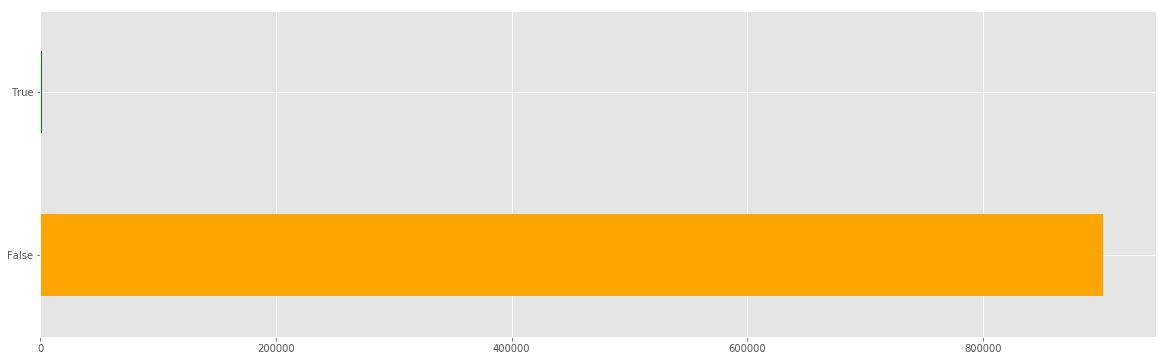

In [193]:
plt.figure(figsize=(20,6))
(train_data.visitStartTime == train_data.visitId).value_counts().plot.barh(color = ["orange","green"])
(train_data.visitStartTime == train_data.visitId).value_counts()

In [196]:
ids_train = set(train_data.fullVisitorId.unique())
ids_test = set(test_data.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 715119
Unique visitor ids in test: 617242
Common visitors in train and test: 0


In [201]:
problem = train_data[train_data.sessionId.map(train_data.sessionId.value_counts() == 2)].sort_values(["sessionId", 'visitStartTime'])
problem

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,content.source,medium.source,vis_date,sess_date_dow,sess_date_hours,sess_date_dom,next_session_1,next_session_2,visitId_dublicates,session_dublicates
212026,12,81418,973,96535,1,96581,8,3,2,13,...,2972,2884,1970-01-02 02:49:41,4,2,2,-2562048,-1,2,2
82177,12,81418,973,96535,1,96598,8,3,2,13,...,2972,2884,1970-01-02 02:49:58,4,2,2,0,-2562048,2,2
848579,14,212255,1269,475734,2,476099,8,3,2,12,...,3137,3656,1970-01-06 12:14:59,1,12,6,0,-1,2,2
802549,14,212255,1269,475734,2,476102,8,3,2,12,...,3137,3656,1970-01-06 12:15:02,1,12,6,0,-2562048,2,2
428607,12,273256,1687,810734,24,811433,8,3,2,12,...,3137,3047,1970-01-10 09:23:53,5,9,10,71,-1,2,2
202287,12,273256,1687,810734,24,811442,8,3,2,12,...,3137,3047,1970-01-10 09:24:02,5,9,10,0,-6,2,2
46654,13,426456,2771,776964,1,777617,8,5,3,14,...,2203,2618,1970-01-10 00:00:17,5,0,10,-2562048,-1,2,2
857846,13,426456,2771,776964,1,777666,8,5,3,14,...,2203,2618,1970-01-10 00:01:06,5,0,10,0,-2562048,2,2
618667,14,533862,3423,524572,4,524982,8,3,2,12,...,3099,3633,1970-01-07 01:49:42,2,1,7,62,-1,2,2
520542,14,533862,3423,524572,4,524997,8,3,2,12,...,3099,3633,1970-01-07 01:49:57,2,1,7,0,-6,2,2


# 第一次模型准备

In [3]:
# Impute 0 for missing target values
train_data["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_data["totals.transactionRevenue"].values
train_data.drop("totals.transactionRevenue",axis=1,inplace=True)

train_id = train_data["fullVisitorId"].values
test_id = test_data["fullVisitorId"].values

In [4]:
#[train_data[column].dtype for column in train_data.columns] 
train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [5]:
cat_cols = [f for f in train_data.columns if not train_data[f].dtype == 'int64']
cat_cols

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitStartTime',
 'device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [6]:
cat_cols.remove('trafficSource.campaign')
cat_cols.remove('trafficSource.campaignCode')
cat_cols

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitStartTime',
 'device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [7]:
for col in cat_cols:
    try:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_data[col].values.astype('str')) + list(test_data[col].values.astype('str')))
        train_data[col] = lbl.transform(list(train_data[col].values.astype('str')))
        test_data[col] = lbl.transform(list(test_data[col].values.astype('str')))
    except:
        print('error',col)

channelGrouping
fullVisitorId
sessionId
visitId
visitStartTime
device.browser
device.deviceCategory
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.bounces
totals.newVisits
totals.pageviews
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source


In [52]:
[(f,train_data[f].dtype) for f in train_data.columns]
[(f,test_data[f].dtype) for f in test_data.columns]

[('channelGrouping', dtype('int64')),
 ('fullVisitorId', dtype('int64')),
 ('sessionId', dtype('int64')),
 ('visitId', dtype('int64')),
 ('visitNumber', dtype('int64')),
 ('visitStartTime', dtype('int64')),
 ('device.browser', dtype('int64')),
 ('device.deviceCategory', dtype('int64')),
 ('device.isMobile', dtype('int64')),
 ('device.operatingSystem', dtype('int64')),
 ('geoNetwork.city', dtype('int64')),
 ('geoNetwork.continent', dtype('int64')),
 ('geoNetwork.country', dtype('int64')),
 ('geoNetwork.metro', dtype('int64')),
 ('geoNetwork.networkDomain', dtype('int64')),
 ('geoNetwork.region', dtype('int64')),
 ('geoNetwork.subContinent', dtype('int64')),
 ('totals.bounces', dtype('int64')),
 ('totals.hits', dtype('int64')),
 ('totals.newVisits', dtype('int64')),
 ('totals.pageviews', dtype('int64')),
 ('trafficSource.adContent', dtype('int64')),
 ('trafficSource.adwordsClickInfo.adNetworkType', dtype('int64')),
 ('trafficSource.adwordsClickInfo.gclId', dtype('int64')),
 ('trafficSour

In [16]:
del train_data['trafficSource.campaign']
del train_data['trafficSource.campaignCode']
del test_data['trafficSource.campaign']
del test_data['trafficSource.campaignCode']
train_data.columns

KeyError: 'trafficSource.campaignCode'

In [17]:
dev_X = train_data.values[:600000]
val_X = train_data.values[600000:]
test_X= test_data

dev_y = np.log1p(train_y[:600000])
val_y = np.log1p(train_y[600000:])

# 基础模型

## 决策树回归

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import tree

### 简单调参

In [19]:
clf = DecisionTreeRegressor(max_depth=4)
clf.fit(dev_X,dev_y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [57]:
print('RMSE:',np.sqrt(metrics.mean_squared_error(val_y, clf.predict(val_X))))

ValueError: Found array with 0 sample(s) (shape=(0, 32)) while a minimum of 1 is required.

In [23]:
# 保存模型
import os     
os.environ["PATH"] += os.pathsep + 'D:\\Anaconda3\\Lib\\site-packages\\graphviz'

from sklearn import tree
with open("GStore.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

# 画图，保存到pdf文件
# 设置图像参数
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=train_data.columns,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# 保存图像到pdf文件
graph.write_pdf("GStore.pdf")

InvocationException: GraphViz's executables not found

In [26]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
with open('tree.dot','w') as f:
    f=export_graphviz(clf,feature_names=train_data.columns,out_file=f)

### 随机森林回归

In [131]:
from sklearn.ensemble import RandomForestRegressor

### 默认参数

In [133]:
rdf = RandomForestRegressor(max_depth=4,class_weight="balanced")
rdf.fit(dev_X,dev_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [134]:
print('RMSE:',np.sqrt(metrics.mean_squared_error(val_y, rdf.predict(val_X))))

RMSE: 1.7409242416619835


### 网格搜索调参

In [139]:
#首先对n_estimators进行网格搜索
param_test1= {'n_estimators':list(range(10,71,10))}
gsearch1= GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,
                                 min_samples_leaf=20,max_depth=4,max_features='sqrt' ,random_state=10),
                       param_grid =param_test1, scoring='r2',cv=5)
gsearch1.fit(dev_X,dev_y)
gsearch1.grid_scores_,gsearch1.best_params_, gsearch1.best_score_

([mean: 0.18768, std: 0.00513, params: {'n_estimators': 10},
  mean: 0.15515, std: 0.00770, params: {'n_estimators': 20},
  mean: 0.14249, std: 0.01149, params: {'n_estimators': 30},
  mean: 0.14616, std: 0.00956, params: {'n_estimators': 40},
  mean: 0.14772, std: 0.00830, params: {'n_estimators': 50},
  mean: 0.15431, std: 0.00705, params: {'n_estimators': 60},
  mean: 0.15051, std: 0.00640, params: {'n_estimators': 70}],
 {'n_estimators': 10},
 0.18767652660487175)

In [149]:
%%time
param_test2= {'max_depth':list(range(3,14,2)), 'min_samples_split':list(range(50,201,20))}
gsearch2= GridSearchCV(estimator = RandomForestRegressor(n_estimators= 10,
                                 min_samples_leaf=20,max_depth=4,max_features='sqrt',random_state=10),
   param_grid = param_test2,scoring='r2',iid=False, cv=5)
gsearch2.fit(dev_X,dev_y)

Wall time: 35min 14s


In [152]:
gsearch2.grid_scores_,gsearch2.best_params_, gsearch2.best_score_

([mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 50},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 70},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 90},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 110},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 130},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 150},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 170},
  mean: 0.14081, std: 0.00224, params: {'max_depth': 3, 'min_samples_split': 190},
  mean: 0.18768, std: 0.00564, params: {'max_depth': 5, 'min_samples_split': 50},
  mean: 0.18723, std: 0.00570, params: {'max_depth': 5, 'min_samples_split': 70},
  mean: 0.19055, std: 0.00884, params: {'max_depth': 5, 'min_samples_split': 90},
  mean: 0.19316, std: 0.00656, params: {'max_depth': 5, 'min_samples_split': 110},
  mean: 0.

In [156]:
#再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3= {'min_samples_split':list(range(80,150,20)), 'min_samples_leaf':list(range(10,60,10))}
gsearch3= GridSearchCV(estimator = RandomForestRegressor(n_estimators= 10,max_depth=13,
                                 max_features='sqrt',random_state=10,min_samples_split=70),
   param_grid = param_test3,scoring='r2',iid=False, cv=5)
gsearch3.fit(dev_X,dev_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=70,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_split': [80, 100, 120, 140], 'min_samples_leaf': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [157]:
gsearch3.grid_scores_,gsearch3.best_params_, gsearch3.best_score_

([mean: 0.28457, std: 0.01173, params: {'min_samples_leaf': 10, 'min_samples_split': 80},
  mean: 0.28168, std: 0.00591, params: {'min_samples_leaf': 10, 'min_samples_split': 100},
  mean: 0.27779, std: 0.01050, params: {'min_samples_leaf': 10, 'min_samples_split': 120},
  mean: 0.27801, std: 0.00544, params: {'min_samples_leaf': 10, 'min_samples_split': 140},
  mean: 0.28007, std: 0.00953, params: {'min_samples_leaf': 20, 'min_samples_split': 80},
  mean: 0.28008, std: 0.01099, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: 0.28175, std: 0.00486, params: {'min_samples_leaf': 20, 'min_samples_split': 120},
  mean: 0.28290, std: 0.01088, params: {'min_samples_leaf': 20, 'min_samples_split': 140},
  mean: 0.27804, std: 0.00923, params: {'min_samples_leaf': 30, 'min_samples_split': 80},
  mean: 0.28119, std: 0.00922, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.28277, std: 0.01306, params: {'min_samples_leaf': 30, 'min_samples_split': 120},
  

In [203]:
rdf_best = RandomForestRegressor(max_depth=13,min_samplces_split=700)
rdf_best.fit(dev_X,dev_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=70,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [204]:
print('RMSE:',np.sqrt(metrics.mean_squared_error(val_y, rdf_best.predict(val_X))))

RMSE: 1.670417167786861


### GBDT框架

In [141]:
from sklearn.ensemble import GradientBoostingRegressor

In [142]:
%%time
gbdt=GradientBoostingRegressor(max_depth=4)
gbdt.fit(dev_X,dev_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [143]:
print('RMSE:',np.sqrt(metrics.mean_squared_error(val_y, gbdt.predict(val_X))))

RMSE: 1.67316696001968


## Lightbm框架

In [211]:
%%time
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 80,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
        "max_depth":14
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, lgb_model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.65493
[200]	valid_0's rmse: 1.64479
[300]	valid_0's rmse: 1.64335
[400]	valid_0's rmse: 1.64345
Early stopping, best iteration is:
[342]	valid_0's rmse: 1.64259
Wall time: 19.7 s


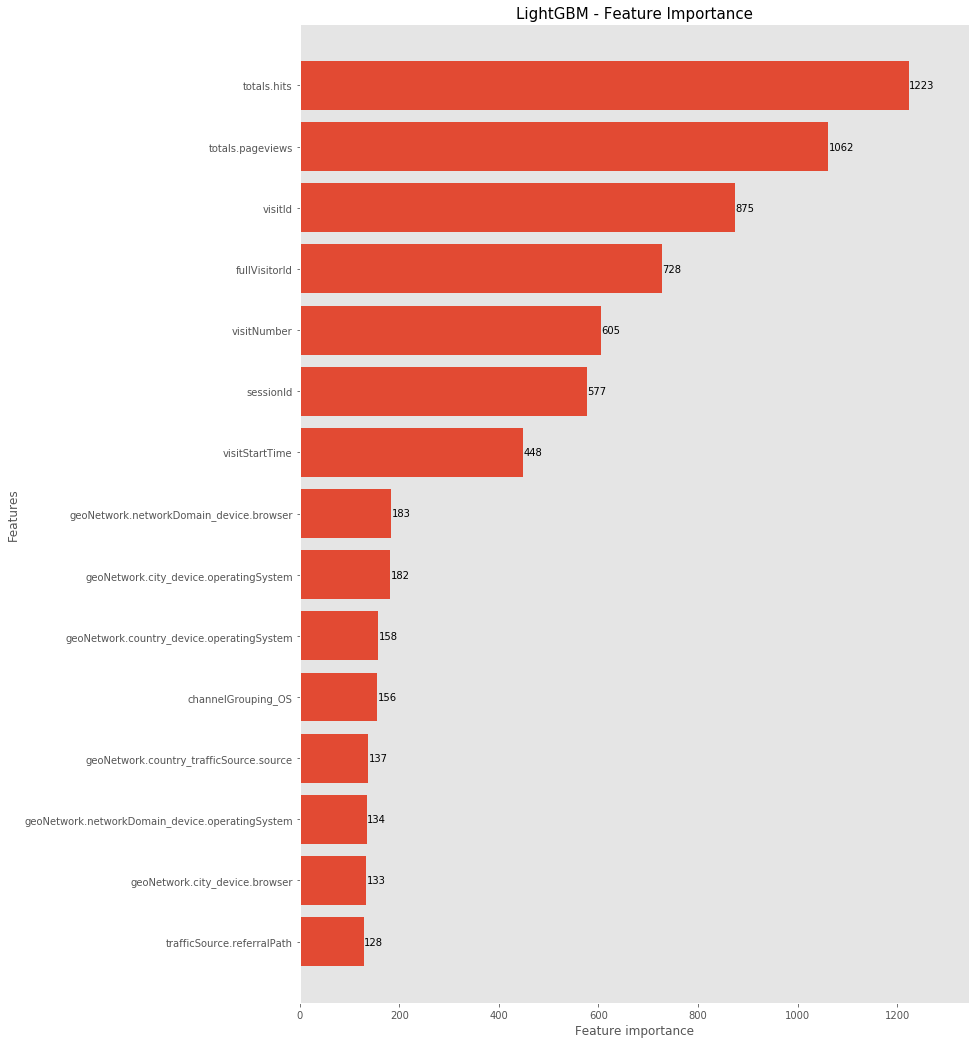

In [216]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model, max_num_features=15, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.savefig('Feature_Importance.png')
plt.show()

## 另一组模型

### 神经网络

In [161]:
from keras import backend as K
import keras
from keras.layers import Dense,BatchNormalization,Dropout
from keras.models import Sequential

In [162]:
K.clear_session()
def build_model(dropout_rate=0.25, activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    
    model.add(Dense(start_neurons, input_dim=dev_X.shape[1], activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(1))
    
    return model

In [177]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
# Impute 0 for missing target values
train_data["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_data["totals.transactionRevenue"].values
train_data.drop("totals.transactionRevenue",axis=1,inplace=True)

train_id = train_data["fullVisitorId"].values
test_id = test_data["fullVisitorId"].values

[train_data[column].dtype for column in train_data.columns] 
train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [164]:
cat_cols = [f for f in train_data.columns if not train_data[f].dtype == 'int64']
num_cols=[f for f in train_data.columns if train_data[f].dtype == 'int64']

In [166]:
all_data=pd.concat([train_data,test_data])
all_data_nums=all_data[num_cols]
for col in cat_cols:
    print(col)
    dummies = pd.get_dummies(all_data[col], prefix = col)
    all_data_nums = pd.concat([all_data_nums,dummies],axis=1) # 将编码结果与非编码特征水平拼接起来
train_data2=all_data[:len(train_data)]
test_data2=all_data[len(test_data):]

vis_date


MemoryError: 

In [ ]:
dev_X = train_data_2[:600000]
val_X = train_data_2[600000:]
test_X= test_data_2

dev_y = np.log1p(train_y[:600000])
val_y = np.log1p(train_y[600000:])

In [188]:
def plot_loss_acc(history):
    plt.figure(figsize=(12,6),dpi=100)
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig('NN.png')
    plt.show()
    
#     plt.plot(history.history['acc'][1:])
#     plt.plot(history.history['val_acc'][1:])
#     plt.title('model Accuracy')
#     plt.ylabel('val_acc')
#     plt.xlabel('epoch')
#     plt.legend(['train','Validation'], loc='upper left')
#     plt.show()

In [169]:
from keras.callbacks import ModelCheckpoint

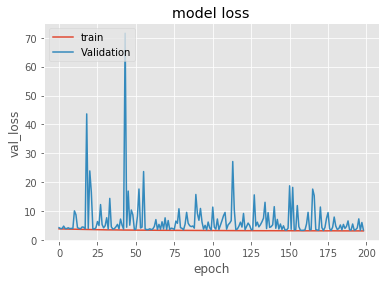

KeyError: 'acc'

In [179]:
K.clear_session()
#checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
model = build_model(dropout_rate=0.25)    
model.compile(loss='mse',optimizer='adam',metrics=[rmse])
history = model.fit(dev_X, dev_y,
                    validation_data=[val_X,val_y], 
                    epochs=200,
                    batch_size=64,shuffle=True,verbose=0)


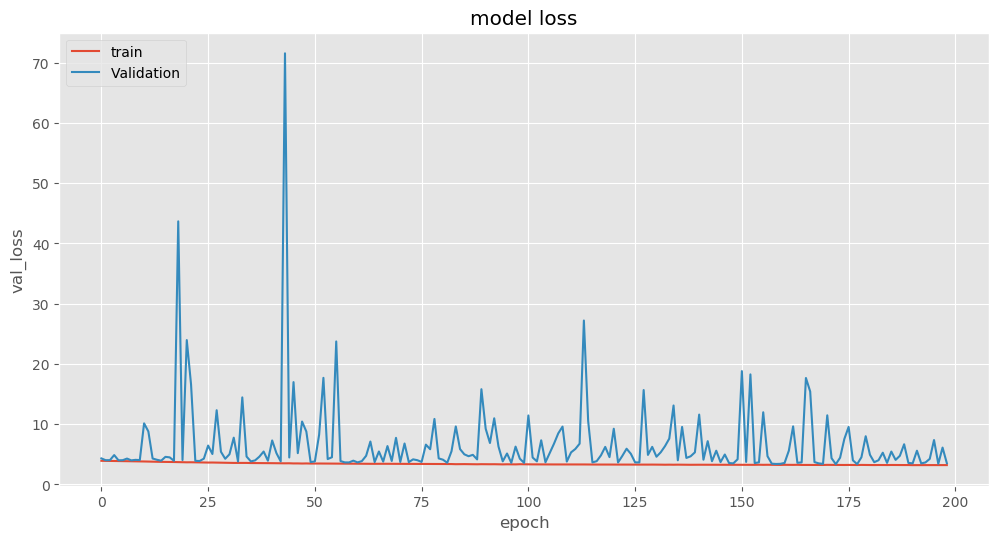

In [189]:
plot_loss_acc(history)

In [182]:
cost = model.evaluate(val_X, val_y, batch_size=64)

303653/303653 [==============================] - ETA:  - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [205]:
print('RMSE:',np.sqrt(metrics.mean_squared_error(val_y, model.predict(val_X))))

RMSE: 1.8794100183415894


In [221]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True) 

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [185]:
W, b = model.layers[0].get_weights()
W

array([[-22.838783  ,  -7.7528114 ,  -3.7880604 , ...,  -0.05869076,
        -10.953599  , -14.110789  ],
       [ -0.28339386,  -0.16608453,  -0.08297984, ...,  -0.02410991,
         -0.08154438,  -0.14441645],
       [  0.1187827 ,  -0.14252864,  -0.87731105, ...,   0.23524392,
         -0.20255603,  -0.28092802],
       ...,
       [  9.839907  ,   4.753197  ,  -3.1255639 , ...,  -0.65643805,
          3.3653696 ,   6.0703273 ],
       [ -3.097857  ,   5.6064353 ,  -3.3455968 , ...,  -1.6217946 ,
          1.0030689 ,  -4.108475  ],
       [-12.188073  ,  -1.0336215 ,  -3.2271547 , ...,  -0.98654366,
         -4.1730347 ,  -9.184874  ]], dtype=float32)

### 特征工程

In [187]:
for df in [train_data, test_data]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
    # remember session dublicates?
    df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

In [75]:
for df in [train_data, test_data]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

['campaignCode']

In [103]:
df = pd.concat([train_data, test_data])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train_data = df[:len(train_data)]
test_data = df[len(train_data):]

In [ ]:
for df in [train_data, test_data]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [ ]:
for df in [train_data, test_data]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

In [ ]:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [ ]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [ ]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [ ]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [ ]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [ ]:
for to_del in ["date", "sessionId", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

In [ ]:
train.to_csv('train_session.csv',index=False)
test.to_csv('test_session.csv',index=False)

### 真正开始构建模型

In [ ]:
from sklearn.model_selection import GroupKFold
class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

Kfolder = KFoldValidation(train_data)

lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [ ]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

In [ ]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

### 第二层级的模型构建——用户层级

In [ ]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [151]:
user_train = create_user_df(train_data)
user_test = create_user_df(test_data)

KeyError: 'date'

In [55]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = pd.concat(train_data['fullVisitorId'], train_data['totals.transactionRevenue']],axis=1).groupby('fullVisitorId').sum()

In [ ]:
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

In [ ]:
user_train.to_csv('train_user.csv',index=False)
user_test.to_csv('test_user.csv',index=False)

### 最终模型

In [ ]:
user_train=pd.read_csv('train_user.csv',dtype={'fullVisitorId': str})
user_test=pd.read_csv('test_user.csv',dtype={'fullVisitorId': str})

In [224]:
#y_train=np.log1p(user_train["totals.transactionRevenue"])
features=['visitNumber', 'device.isMobile', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.isTrueDirect', 'Sessions', 'Avg. Session Duration', 'Bounce Rate', 'Revenue', 'Transactions', 'Goal Conversion Rate', 'id_incoherence', 'visitId_dublicates', 'session_dublicates', 'time', 'prev_session', 'next_session', 'usermean_totals.hits', 'usermean_totals.pageviews', 'usermax_visitNumber', 'channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'weekday', 'source.country', 'campaign.medium', 'browser.category', 'browser.os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork.city_device.browser', 'geoNetwork.city_device.deviceCategory', 'geoNetwork.city_device.operatingSystem', 'geoNetwork.city_trafficSource.source', 'geoNetwork.continent_device.browser', 'geoNetwork.continent_device.deviceCategory', 'geoNetwork.continent_device.operatingSystem', 'geoNetwork.continent_trafficSource.source', 'geoNetwork.country_device.browser', 'geoNetwork.country_device.deviceCategory', 'geoNetwork.country_device.operatingSystem', 'geoNetwork.country_trafficSource.source', 'geoNetwork.metro_device.browser', 'geoNetwork.metro_device.deviceCategory', 'geoNetwork.metro_device.operatingSystem', 'geoNetwork.metro_trafficSource.source', 'geoNetwork.networkDomain_device.browser', 'geoNetwork.networkDomain_device.deviceCategory', 'geoNetwork.networkDomain_device.operatingSystem', 'geoNetwork.networkDomain_trafficSource.source', 'geoNetwork.region_device.browser', 'geoNetwork.region_device.deviceCategory', 'geoNetwork.region_device.operatingSystem', 'geoNetwork.region_trafficSource.source', 'geoNetwork.subContinent_device.browser', 'geoNetwork.subContinent_device.deviceCategory', 'geoNetwork.subContinent_device.operatingSystem', 'geoNetwork.subContinent_trafficSource.source', 'content.source', 'medium.source', 'pred_0', 'pred_1', 'pred_10', 'pred_100', 'pred_101', 'pred_102', 'pred_103', 'pred_104', 'pred_105', 'pred_106', 'pred_107', 'pred_108', 'pred_109', 'pred_11', 'pred_110', 'pred_111', 'pred_112', 'pred_113', 'pred_114', 'pred_115', 'pred_116', 'pred_117', 'pred_118', 'pred_119', 'pred_12', 'pred_120', 'pred_121', 'pred_122', 'pred_123', 'pred_124', 'pred_125', 'pred_126', 'pred_127', 'pred_128', 'pred_129', 'pred_13', 'pred_130', 'pred_131', 'pred_132', 'pred_133', 'pred_134', 'pred_135', 'pred_136', 'pred_137', 'pred_138', 'pred_139', 'pred_14', 'pred_140', 'pred_141', 'pred_142', 'pred_143', 'pred_144', 'pred_145', 'pred_146', 'pred_147', 'pred_148', 'pred_149', 'pred_15', 'pred_150', 'pred_151', 'pred_152', 'pred_153', 'pred_154', 'pred_155', 'pred_156', 'pred_157', 'pred_158', 'pred_159', 'pred_16', 'pred_160', 'pred_161', 'pred_162', 'pred_163', 'pred_164', 'pred_165', 'pred_166', 'pred_167', 'pred_168', 'pred_169', 'pred_17', 'pred_170', 'pred_171', 'pred_172', 'pred_173', 'pred_174', 'pred_175', 'pred_176', 'pred_177', 'pred_178', 'pred_179', 'pred_18', 'pred_180', 'pred_181', 'pred_182', 'pred_183', 'pred_184', 'pred_185', 'pred_186', 'pred_187', 'pred_188', 'pred_189', 'pred_19', 'pred_190', 'pred_191', 'pred_192', 'pred_193', 'pred_194', 'pred_195', 'pred_196', 'pred_197', 'pred_198', 'pred_199', 'pred_2', 'pred_20', 'pred_200', 'pred_201', 'pred_202', 'pred_203', 'pred_204', 'pred_205', 'pred_206', 'pred_207', 'pred_208', 'pred_209', 'pred_21', 'pred_210', 'pred_211', 'pred_212', 'pred_213', 'pred_214', 'pred_215', 'pred_216', 'pred_217', 'pred_218', 'pred_219', 'pred_22', 'pred_220', 'pred_221', 'pred_222', 'pred_223', 'pred_224', 'pred_225', 'pred_226', 'pred_227', 'pred_228', 'pred_229', 'pred_23', 'pred_230', 'pred_231', 'pred_232', 'pred_233', 'pred_234', 'pred_235', 'pred_236', 'pred_237', 'pred_238', 'pred_239', 'pred_24', 'pred_240', 'pred_241', 'pred_242', 'pred_243', 'pred_244', 'pred_245', 'pred_246', 'pred_247', 'pred_248', 'pred_249', 'pred_25', 'pred_250', 'pred_251', 'pred_252', 'pred_253', 'pred_254', 'pred_255', 'pred_256', 'pred_257', 'pred_258', 'pred_259', 'pred_26', 'pred_260', 'pred_261', 'pred_262', 'pred_263', 'pred_264', 'pred_265', 'pred_266', 'pred_267', 'pred_268', 'pred_269', 'pred_27', 'pred_270', 'pred_271', 'pred_272', 'pred_273', 'pred_274', 'pred_275', 'pred_276', 'pred_277', 'pred_28', 'pred_29', 'pred_3', 'pred_30', 'pred_31', 'pred_32', 'pred_33', 'pred_34', 'pred_35', 'pred_36', 'pred_37', 'pred_38', 'pred_39', 'pred_4', 'pred_40', 'pred_41', 'pred_42', 'pred_43', 'pred_44', 'pred_45', 'pred_46', 'pred_47', 'pred_48', 'pred_49', 'pred_5', 'pred_50', 'pred_51', 'pred_52', 'pred_53', 'pred_54', 'pred_55', 'pred_56', 'pred_57', 'pred_58', 'pred_59', 'pred_6', 'pred_60', 'pred_61', 'pred_62', 'pred_63', 'pred_64', 'pred_65', 'pred_66', 'pred_67', 'pred_68', 'pred_69', 'pred_7', 'pred_70', 'pred_71', 'pred_72', 'pred_73', 'pred_74', 'pred_75', 'pred_76', 'pred_77', 'pred_78', 'pred_79', 'pred_8', 'pred_80', 'pred_81', 'pred_82', 'pred_83', 'pred_84', 'pred_85', 'pred_86', 'pred_87', 'pred_88', 'pred_89', 'pred_9', 'pred_90', 'pred_91', 'pred_92', 'pred_93', 'pred_94', 'pred_95', 'pred_96', 'pred_97', 'pred_98', 'pred_99', 't_mean', 't_median', 't_sum_log', 't_sum_act', 't_nb_sess']

In [225]:
len(features)

360

In [ ]:
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

In [ ]:
Kfolder = KFoldValidation(user_train)

In [ ]:
lgb1 = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.01, bagging_fraction=0.7, feature_fraction=0.9, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

Kfolder.validate(user_train, user_test, features, lgb1, name="lgb1", prepare_stacking=True)

In [ ]:
lgb2 = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=35, min_child_samples=100,
                      learning_rate=0.01, bagging_fraction=0.9, feature_fraction=0.8, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [ ]:
Kfolder.validate(user_train, user_test, features, lgb2, name="lgb2", prepare_stacking=True)

In [18]:
lgb3 = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=40, min_child_samples=100,
                      learning_rate=0.01, bagging_fraction=0.9, feature_fraction=0.8, bagging_frequency=2, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

Kfolder.validate(user_train, user_test, features, lgb3, name="lgb3", prepare_stacking=True)

lgb4 = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=45, min_child_samples=100,
                      learning_rate=0.01, bagging_fraction=0.6, feature_fraction=0.6, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [24]:
Kfolder.validate(user_train, user_test, features, lgb4, name="lgb4", prepare_stacking=True)

In [25]:
lgb5 = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=40, min_child_samples=100,
                      learning_rate=0.01, bagging_fraction=0.95, feature_fraction=1, bagging_frequency=1, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [26]:
Kfolder.validate(user_train, user_test, features, lgb5, name="lgb5", prepare_stacking=True)

In [27]:
cat1 = cat.CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=2019)

process device ...
process device ...


In [ ]:
Kfolder.validate(user_train, user_test, features, cat1, name="cat1", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

In [ ]:
cat2 = cat.CatBoostRegressor(iterations=700, learning_rate=0.1, depth=5, random_seed=2019)

In [ ]:
Kfolder.validate(user_train, user_test, features, cat2, name="cat2", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

In [ ]:
cat3 = cat.CatBoostRegressor(iterations=750, learning_rate=0.1, depth=4, random_seed=2019)

In [25]:
Kfolder.validate(user_train, user_test, features, cat3, name="cat3", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

In [ ]:
cat4 = cat.CatBoostRegressor(iterations=800, learning_rate=0.1, depth=3, random_seed=2019)

In [27]:
Kfolder.validate(user_train, user_test, features, cat4, name="cat4", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

In [ ]:
xgb1 = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.8, colsample_bytree=0.054, colsample_bylevel=0.50)

In [ ]:
Kfolder.validate(user_train, user_test, features, xgb1, name="xgb1", prepare_stacking=True)

In [ ]:
xgb2 = xgb.XGBRegressor(max_depth=15, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [ ]:
Kfolder.validate(user_train, user_test, features, xgb2, name="xgb2", prepare_stacking=True)

In [ ]:
xgb3 = xgb.XGBRegressor(max_depth=25, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.55, colsample_bytree=0.2, colsample_bylevel=0.50)

In [ ]:
Kfolder.validate(user_train, user_test, features, xgb3, name="xgb3", prepare_stacking=True)

In [ ]:
models=["lgb1","lgb2","lgb3","lgb4","lgb5","cat1","cat2","cat3","cat4","xgb1","xgb2","xgb3"]

In [ ]:
#### 集成模型一——Lasso回归模型

In [ ]:
lasso =make_pipeline(RobustScaler(), Lasso(alpha =2, random_state=1))

In [ ]:
lasso.fit(user_train[models],np.log1p(user_train["totals.transactionRevenue"]))

In [ ]:
#### 集成模型二——xgboost模型

In [ ]:
xgb_all = xgb.XGBRegressor(max_depth=4, learning_rate=0.02, n_estimators=500, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [ ]:
xgb_all.fit(user_train[models],np.log1p(user_train["totals.transactionRevenue"]))

In [ ]:
score(user_train,xgb_all.predict(user_train[models]))#lasso.predict(user_train[['lgb1','lgb2','cat1','cat2','xgb1']]) )#lasso.predict(user_train[models])#0.2*user_train['lgb1']+0.25*user_train['lgb2']+0.25*user_train['cat3']+0.2*user_train['cat4']+0.1*user_train['xgb1']

In [ ]:
#predict=0.7*xgb_all.predict(user_test[models])+0.2*user_test['lgb2']+0.1*user_test['xgb1']
predict=0.2*user_test['lgb1']+0.23*user_test['lgb2']+0.25*user_test['cat3']+0.2*user_test['cat4']+0.12*user_test['xgb1']
predict[predict<0]=0
user_test['PredictedLogRevenue']=predict
user_test[['fullVisitorId','PredictedLogRevenue']].to_csv('final_leak_check_submission.csv', index=False)

In [ ]:
import datetime
print('训练完成',datetime.datetime.now())